In [1]:
import pandas as pd
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
import os
import jenkspy
import seaborn as sns
import altair_latimes as lat
import altair as alt
from pandas.io.json import json_normalize 
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

In [2]:
key = "sg5Q11oWW9pqLtmn8gVS0nOS179RousHDpeTgZkA"

In [3]:
formaturl = lambda x: 'https://api.propublica.org/congress/v1/' + f'{x[0]}/' + f'{x[1]}' + '/members.json'

In [4]:
metadata = []
for s in range(104, 117):
    for c in ['house', 'senate']:
        metadata.append(dict(chamber = c, session = s, url = formaturl((s, c))))

In [5]:
jsons = []
for m in metadata:
    r = requests.get(m['url'], headers={"X-API-KEY":key})
    d = r.json()
    m['datadict'] = d
    jsons.append(m)

In [6]:
def processdict(d):
    data = json_normalize(d['datadict']['results'], record_path=['members'])
    data['chamber'] = d['chamber']
    data['session'] = d['session']
    return data

In [7]:
ap_states = {'AL':'Ala.',
    'AK':'Alaska',
    'AZ':'Ariz.',
    'AR':'Ark.',
    'CA':'Calif.',
    'CO':'Colo.',
    'CT':'Conn.',
    'DE':'Del.',
    'FL':'Fla.',
    'GA':'Ga.',
    'HI':'Hawaii',
    'IA':'Iowa',
    'ID':'Idaho',
    'IL':'Ill.',
    'IN':'Ind.',
    'KS':'Kan.',
    'KY':'Ky.',
    'LA':'La.',
    'MD':'Md.',
    'MA':'Mass.',
    'ME':'Maine',
    'MI':'Mich.',
    'MN':'Minn.',
    'MS':'Miss.',
    'MO':'Mo.',
    'MT':'Mont.',
    'NE':'Neb.',
    'NV':'Nev.',
    'NH':'N.H.',
    'NJ':'N.J.',
    'NM':'N.M.',
    'NY':'N.Y.',
    'NC':'N.C.',
    'ND':'N.D.',
    'OH': 'Ohio',
    'OK':'Okla.',
    'OR':'Ore.',
    'PA':'Pa.',
    'RI':'R.I.',
    'SC':'S.C.',
    'SD':'S.D.',
    'TX':'Texas',
    'TN':'Tenn.',
    'VT':'Vt.',
    'VA':'Va.',
    'WA':'Wash.',
    'WV':'W.Va.',
    'WI':'Wis.',
    'WY':'Wyo'}

In [8]:
alldata = pd.concat([processdict(j) for j in jsons], sort=False)

In [9]:
alldata['apstate'] = alldata['state'].map(ap_states)

In [10]:
alldata['full_name'] = alldata['first_name'] + ' ' + alldata['last_name']

In [11]:
a_member = alldata[(alldata.full_name == 'Nancy Pelosi') &\
                  ((alldata.session == 105) | \
                   (alldata.session == 116))][['id', 'seniority', 'full_name', 'first_name', 'last_name', 'chamber',\
                                                'session', 'state', 'apstate', 'party', 'dw_nominate', 'votes_with_party_pct']]

In [12]:
members_slim = alldata[['id', 'seniority', 'full_name', 'apstate', 'first_name', 'last_name', 'chamber',\
                                                'session', 'state', 'party', 'dw_nominate', 'votes_with_party_pct']]

In [13]:
members_slim.to_csv('output/members_slim.csv')

In [14]:
then = members_slim[(members_slim['session'] == 105) & (members_slim['chamber'] == 'house')]

In [15]:
now = members_slim[(members_slim['session'] == 115) & (members_slim['chamber'] == 'house')]

In [16]:
both = pd.merge(then,now,on='id', how='inner')

In [17]:
exclude = ['S000033','P000258','J000255','N000147']

In [18]:
both = both[~both.id.isin(exclude)]

### Where are the outliers (or, who's changed the most)?

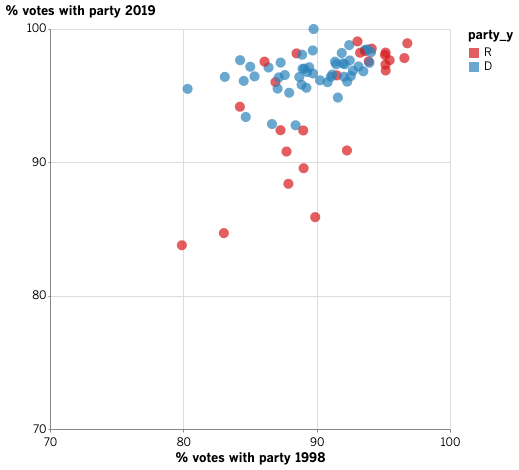

In [19]:
alt.Chart(both).mark_circle(size=100).encode(
    x = alt.X('votes_with_party_pct_x:Q',
        scale=alt.Scale(domain=(70, 100)), axis = alt.Axis(tickCount=4,title = '% votes with party 1998')),
    y = alt.Y('votes_with_party_pct_y:Q',
        scale=alt.Scale(domain=(70, 100)), axis = alt.Axis(tickCount=4, title = '% votes with party 2019')),
    color=alt.Color('party_y:N',
                   scale=alt.Scale(domain=['R', 'D'],range=['#d7191c', '#2b83ba'])),
    tooltip=['full_name_x:N', 'party_x', 'id', 'votes_with_party_pct_y', 'votes_with_party_pct_x']
).properties(width=400,height=400)

In [20]:
both_sessions = pd.DataFrame(both[['full_name_x', 'id', 'state_y', 'apstate_y', 'party_y', 'votes_with_party_pct_x', \
                                   'votes_with_party_pct_y', ]])

In [21]:
both_sessions.groupby('party_y').agg('size')

party_y
D    48
R    26
dtype: int64

In [22]:
both_sessions.rename(columns={'full_name_x':'member',
                              'state_y':'state',
                              'apstate_y':'apstate',
                          'party_y':'party',
                          'votes_with_party_pct_x':'before',
                            'votes_with_party_pct_y': 'after'}, 
                 inplace=True)

In [23]:
both_sessions['change'] = both_sessions['after'] - both_sessions['before']
both_sessions['label'] = both_sessions['member'] + ' (' + both_sessions['party'] + '-' + both_sessions['apstate'] + ')'

In [24]:
both_sessions.head(100)

,member,id,state,apstate,party,before,after,change,label
0,Robert Aderholt,A000055,AL,Ala.,R,93.90,97.58,3.68,Robert Aderholt (R-Ala.)
1,Joe Barton,B000213,TX,Texas,R,91.51,96.52,5.01,Joe Barton (R-Texas)
2,Xavier Becerra,B000287,CA,Calif.,D,89.77,100.00,10.23,Xavier Becerra (D-Calif.)
3,Sanford Bishop,B000490,GA,Ga.,D,84.68,93.40,8.72,Sanford Bishop (D-Ga.)
4,Earl Blumenauer,B000574,OR,Ore.,D,91.59,94.86,3.27,Earl Blumenauer (D-Ore.)
5,Kevin Brady,B000755,TX,Texas,R,94.13,98.53,4.40,Kevin Brady (R-Texas)
6,Robert Brady,B001227,PA,Pa.,D,92.11,97.35,5.24,Robert Brady (D-Pa.)
7,Ken Calvert,C000059,CA,Calif.,R,96.58,97.82,1.24,Ken Calvert (R-Calif.)
8,Steven Chabot,C000266,OH,Ohio,R,88.49,98.17,9.68,Steven Chabot (R-Ohio)
9,James Clyburn,C000537,SC,S.C.,D,88.91,98.07,9.16,James Clyburn (D-S.C.)


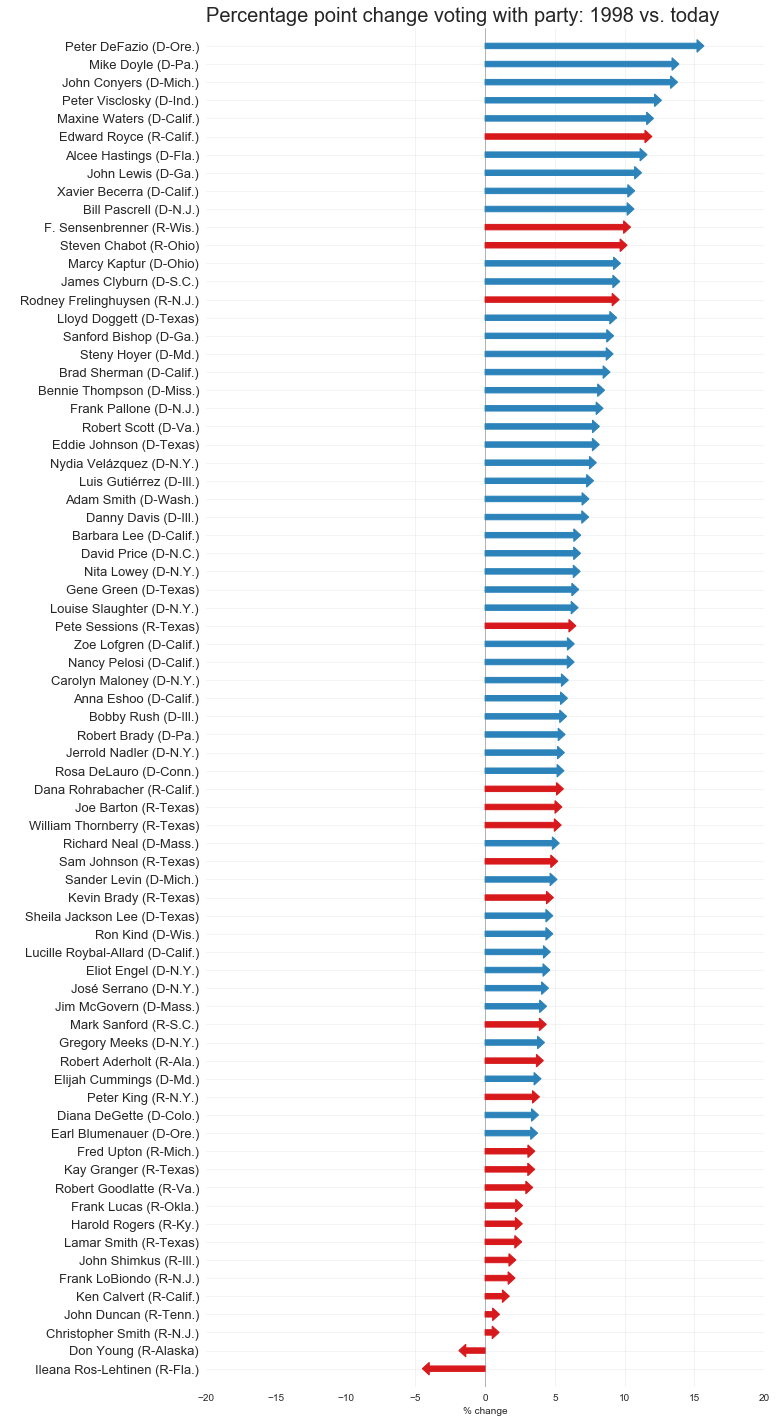

In [25]:
data = both_sessions.sort_values(by='change', ascending=True) \
           .reset_index(drop=True)

n = 74
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,25))
ax.set_xlim(-1,0)
ax.set_ylim(-1,n)
ax.set_yticks(range(n))
ax.set_yticklabels(data['label'],fontsize=13)

arrow_starts = np.repeat(0,n)
arrow_lengths = data['change'].values

for i, subject in enumerate(data['label']):
    
    if data['party'][i] == 'R':
        arrow_color = '#d7191c'
    elif data['party'][i] == 'D':
        arrow_color = '#2b83ba'
    else:
        arrow_color = 'black'
    
    ax.arrow(arrow_starts[i],   
             i,                      
             arrow_lengths[i],       
             0,                      
             head_width=0.7,         
             head_length=0.5,        
             width=0.3,              
             fc=arrow_color,         
             ec=arrow_color)         
    
#format plot
ax.set_title('Percentage point change voting with party: 1998 vs. today',fontsize=20, loc='left') 
ax.axvline(x=0, color='0.7', ls='-', lw=1, zorder=1) 
ax.axvline(x=5, color='0.9', ls='-', lw=.5, zorder=1) 
ax.axvline(x=10, color='0.9', ls='-', lw=.5, zorder=1) 
ax.axvline(x=15, color='0.9', ls='-', lw=.5, zorder=1) 
ax.axvline(x=-5, color='0.9', ls='-', lw=.5, zorder=1) 
ax.grid(axis='y', color='0.94')                        
ax.set_xlim(-20,20)                                    
ax.set_xlabel('% change')                               
ax.set_ylabel(' ')                          
sns.despine(left=True, bottom=True)                  

In [26]:
both_sessions.to_csv('output/both_sessions.csv')

### Download headshots of members who served both congresses

In [27]:
os.chdir('/Users/mhustiles/data/github/notebooks/congress/output/headshots')

In [28]:
formaturl = lambda x: 'http://raw.githubusercontent.com/unitedstates/images/gh-pages/congress/225x275/' + f'{i}' + '.jpg'

In [29]:
urls = []
for i in both_sessions['id']:
        urls.append(formaturl((i)))

In [30]:
for i in urls:
    !curl -O -s {i}